Для анализа выбран датасет **Banana Quality**. Данные содержат поведенческую информацию о 200 клиентах торгового центра.

**Характеристики данных:**
*   **Объем:** 8000 записей, 8 признаков.
*   **Тип признаков:** Числовые (Size, Weight, Sweetness, Softness, HarvestTime, Ripeness, Acidity) и категориальный (Quality).

Для кластеризации использовались 7 числовых признаков: размер (Size), вес (Weight), сладость (Sweetness), мягкость (Softness), время сбора урожая (HarvestTime), степень зрелости (Ripeness) и кислотность (Acidity).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
import scipy.cluster.hierarchy as shc
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, rand_score, adjusted_rand_score, jaccard_score, pairwise_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from pandas.plotting import scatter_matrix
from sklearn.cluster import KMeans, AgglomerativeClustering
warnings.filterwarnings('ignore')


sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


df = pd.read_csv('banana_quality.csv')

print("Основная информация о датасете")
print("\n")
print(f"Размерность данных: {df.shape}")
print(f"Количество строк: {df.shape[0]}")
print(f"Количество столбцов: {df.shape[1]}")
print("Первые 5 строк:")
print("\n")
df.head()



Основная информация о датасете


Размерность данных: (8000, 8)
Количество строк: 8000
Количество столбцов: 8
Первые 5 строк:




,Size,Weight,Sweetness,Softness,HarvestTime,Ripeness,Acidity,Quality
0,-1.924968,0.468078,3.077832,-1.472177,0.294799,2.435570,0.271290,Good
1,-2.409751,0.486870,0.346921,-2.495099,-0.892213,2.067549,0.307325,Good
2,-0.357607,1.483176,1.568452,-2.645145,-0.647267,3.090643,1.427322,Good
3,-0.868524,1.566201,1.889605,-1.273761,-1.006278,1.873001,0.477862,Good
4,0.651825,1.319199,-0.022459,-1.209709,-1.430692,1.078345,2.812442,Good


In [2]:
print("Описательная статистика:")
print("\n")
df.describe()

Описательная статистика:




,Size,Weight,Sweetness,Softness,HarvestTime,Ripeness,Acidity
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,-0.747802,-0.761019,-0.770224,-0.014441,-0.751288,0.781098,0.008725
std,2.136023,2.015934,1.948455,2.065216,1.996661,2.114289,2.293467
min,-7.998074,-8.283002,-6.434022,-6.959320,-7.570008,-7.423155,-8.226977
25%,-2.277651,-2.223574,-2.107329,-1.590458,-2.120659,-0.574226,-1.629450
50%,-0.897514,-0.868659,-1.020673,0.202644,-0.934192,0.964952,0.098735
75%,0.654216,0.775491,0.311048,1.547120,0.507326,2.261650,1.682063
max,7.970800,5.679692,7.539374,8.241555,6.293280,7.249034,7.411633


In [3]:
print("\nПропуски:")
print("\n")
print(df.isnull().sum())


Пропуски:


Size           0
Weight         0
Sweetness      0
Softness       0
HarvestTime    0
Ripeness       0
Acidity        0
Quality        0
dtype: int64


В данном датасете отсутствуют пропуски

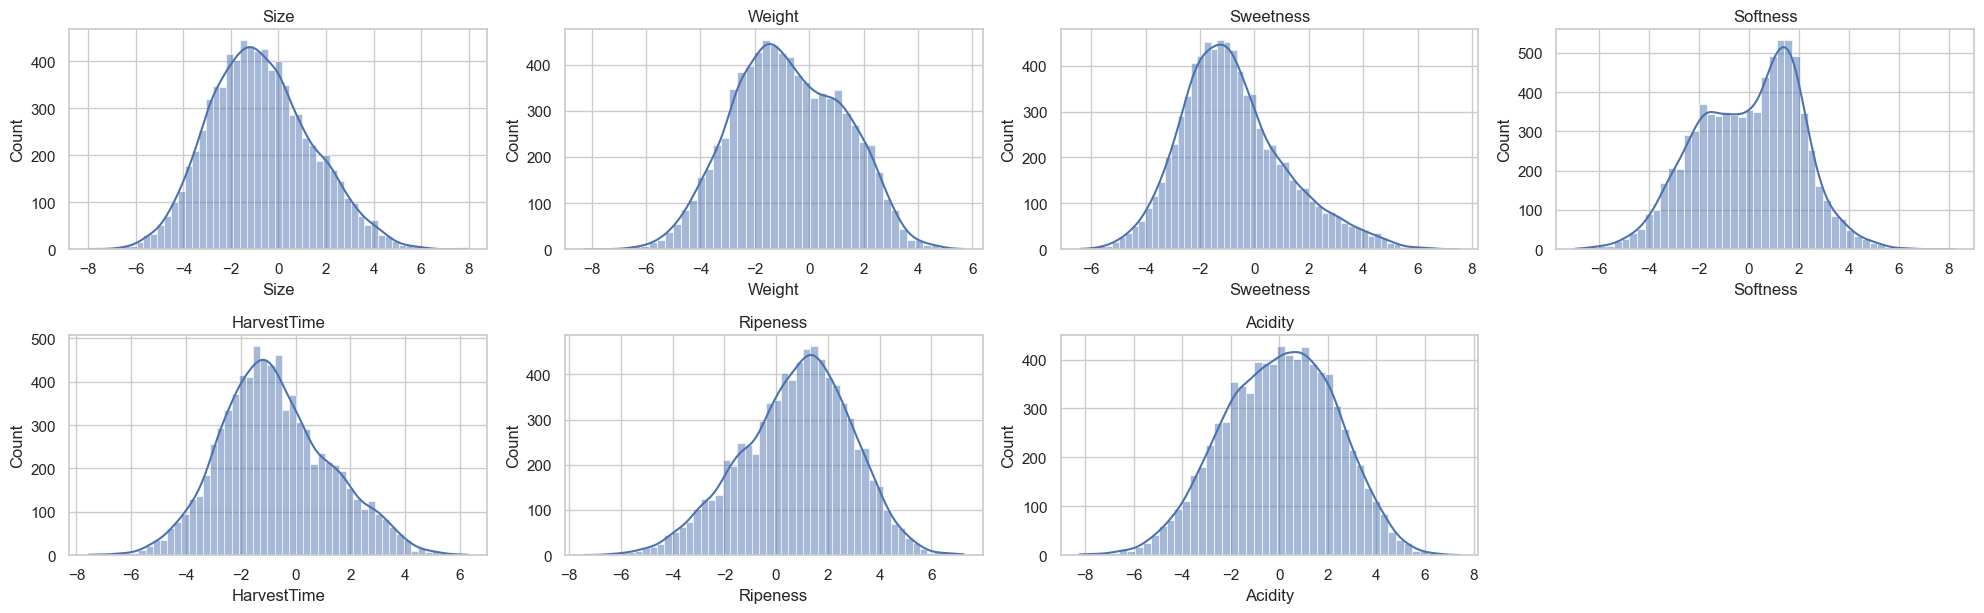

In [4]:
df.drop('Quality', axis=1, inplace=True)
plt.figure(figsize=(20, 15))
for i, col in enumerate(df.columns):
    plt.subplot(5, 4, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

**Анализ распределений числовых признаков по гистограммам**-

Size (Размер)
Распределение: унимодальное.
Особенности: симметричное, «колокольное», без длинных хвостов.
Близость к нормальному: высокая.

Weight (Вес)
Распределение: унимодальное.
Особенности: асимметрия влево.
Близость к нормальному: распределение не нормальное

Sweetness (Сладость)
Распределение: унимодальное с выраженной положительной асимметрией (правосторонний хвост).
Особенности: мода смещена вправо, плавный спад слева.
Нормальность: не соответствует нормальному — имеет наибольшую асимметрию среди всех признаков.

Softness (Мягкость)
Распределение: биомодальное.
Особенности: две выраженные моды → смесь двух групп.
Близость к нормальному: низкая, распределение не нормальное.

HarvestTime (Время сбора урожая)
Распределение: унимодальное с заметной асимметрией влево.
Особенности: хвост тянется влево, пик смещён вправо.
Близость к нормальному: низкая.

Ripeness (Зрелость)
Распределение: унимодальное.
Особенности: слабая асимметрия.
Близость к нормальному: высокая.

Acidity (Кислотность)
Распределение: унимодальное.
Особенности: форма симметричная.
Близость к нормальному: высокая.


Признаки Sweetness, Softness, Size и Acidity будут играть ключевую роль в разделении данных на кластеры

In [5]:
# Анализ выбросов
print("\nАнализ выбросов:")
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()

for col in df.columns:
    print(f"   - {col}: {outliers[col]} выбросов ({outliers[col]/len(df)*100:.1f}%)")



Анализ выбросов:
   - Size: 36 выбросов (0.4%)
   - Weight: 3 выбросов (0.0%)
   - Sweetness: 178 выбросов (2.2%)
   - Softness: 9 выбросов (0.1%)
   - HarvestTime: 58 выбросов (0.7%)
   - Ripeness: 58 выбросов (0.7%)
   - Acidity: 17 выбросов (0.2%)


Выбросов достаточно мало и они не являются критическими

Корреляционный анализ признаков бананов:



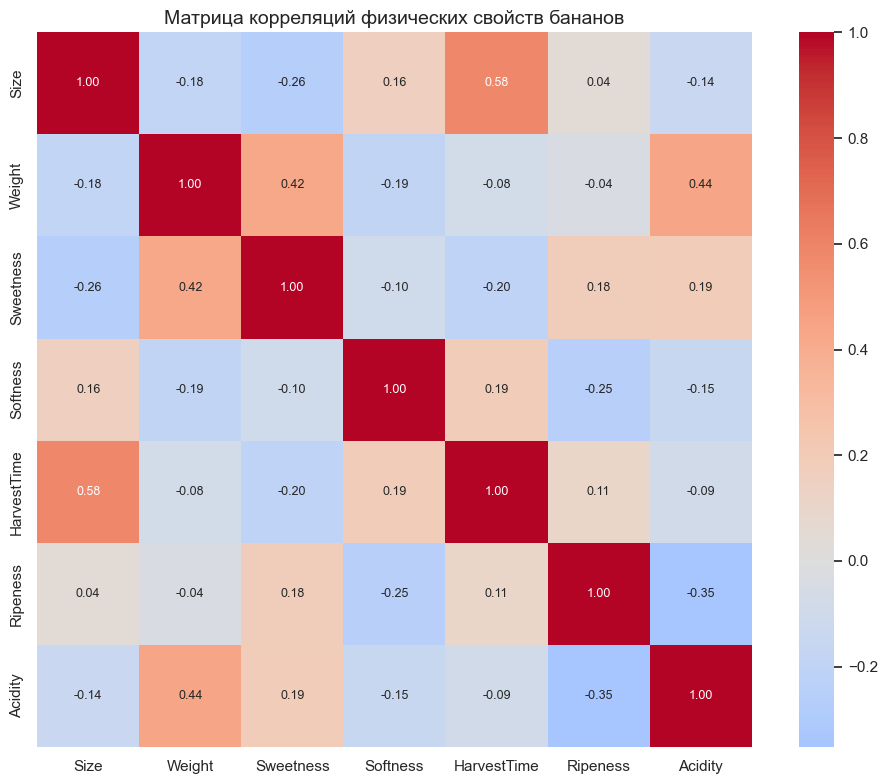


Значительные корреляции (|r| > 0.5):
   - Size - HarvestTime: 0.582


In [6]:
print("Корреляционный анализ признаков бананов:\n")

# Используем все числовые признаки (Quality уже удален)
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', annot_kws={'size': 9})
plt.title('Матрица корреляций физических свойств бананов', fontsize=14)
plt.tight_layout()
plt.show()

print("\nЗначительные корреляции (|r| > 0.5):")
strong_correlations = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]
            strong_correlations.append((col1, col2, corr_val))

if strong_correlations:
    for col1, col2, corr in strong_correlations:
        print(f"   - {col1} - {col2}: {corr:.3f}")
else:
    print("   - Сильных корреляций (> 0.5) не обнаружено")

Корреляция 0.582 - умеренная, не критичная для кластеризации. Оба признака имеют ясную физическую интерпретацию

В результате обработки данных для кластеризации была удалена категориальная переменная quality.

## Предобработка данных

In [7]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

## Построение матрицы диаграмм рассеивания

<Figure size 1500x1500 with 0 Axes>

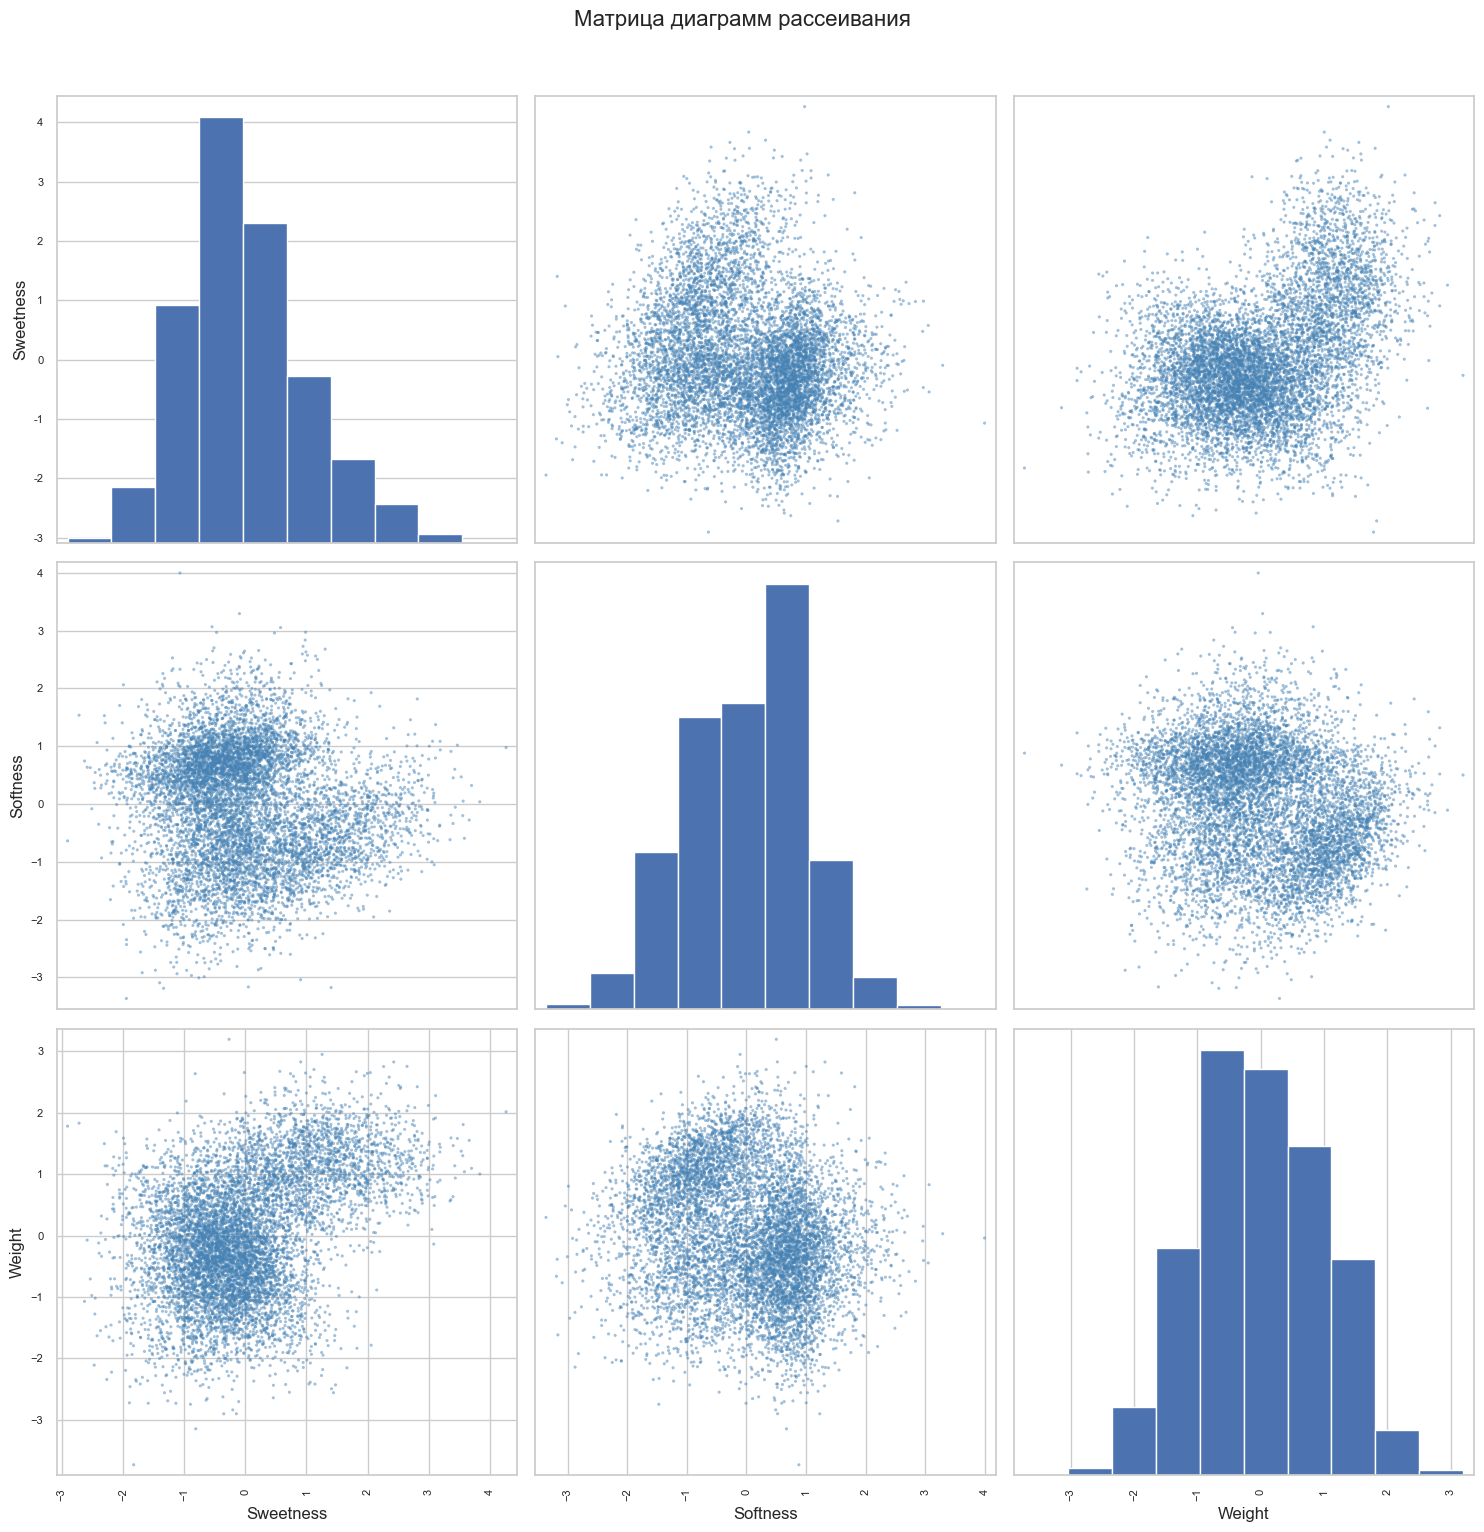

In [18]:
informative_features = ['Sweetness', 'Softness', 'Weight']
df_top = df_scaled[informative_features].copy()

plt.figure(figsize=(15, 15))
pd.plotting.scatter_matrix(df_top, alpha=0.5, figsize=(15, 15), 
                          diagonal='hist', marker='.', s=20,
                          color='steelblue', grid=True)

plt.suptitle('Матрица диаграмм рассеивания',
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Поиск оптимального количества кластеров

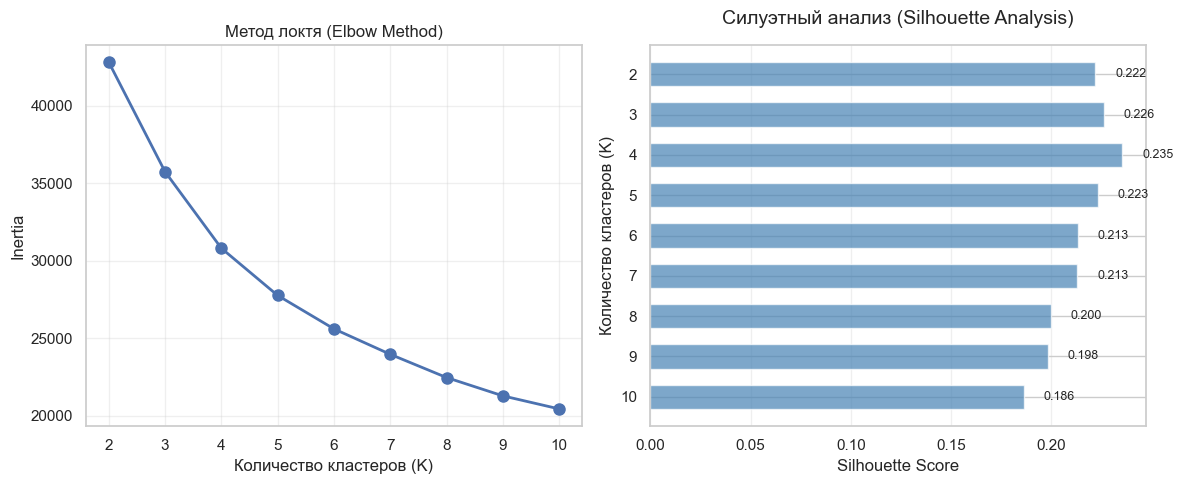

Оптимальное K по силуэту: 4 (score = 0.2354)
Силуэтные коэффициенты для K=[2..10]:
  k=2: 0.2219
  k=3: 0.2262
  k=4: 0.2354
  k=5: 0.2233
  k=6: 0.2133
  k=7: 0.2131
  k=8: 0.1999
  k=9: 0.1983
  k=10: 0.1862


In [9]:
X = df_scaled.values

k_range = range(2, 11)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    
    labels = kmeans.labels_
    if len(set(labels)) > 1:
        silhouette_avg = silhouette_score(X, labels)
    else:
        silhouette_avg = -1
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Количество кластеров (K)')
plt.ylabel('Inertia')
plt.title('Метод локтя (Elbow Method)')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)

plt.subplot(1, 2, 2)
bars = plt.barh(k_range, silhouette_scores, color='steelblue', alpha=0.7, height=0.6)
plt.xlabel('Silhouette Score')
plt.ylabel('Количество кластеров (K)')
plt.title('Силуэтный анализ (Silhouette Analysis)', fontsize=14, pad=15)
plt.yticks(k_range)
plt.grid(True, alpha=0.3, axis='x')
plt.gca().invert_yaxis()

for bar, score in zip(bars, silhouette_scores):
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{score:.3f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

best_k = k_range[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)
print(f"Оптимальное K по силуэту: {best_k} (score = {best_score:.4f})")
print(f"Силуэтные коэффициенты для K=[2..10]:")
for k, score in zip(k_range, silhouette_scores):
    print(f"  k={k}: {score:.4f}")

OPTIMAL_K = 4


Для выбора оптимального числа кластеров $k$ использовались два метода:

Метод локтя (Elbow Method): На графике зависимости инерции от количества кластеров не наблюдается явного "излома", однако замедление уменьшения инерции начинается в районе $k=4$, что может служить ориентиром.

Силуэтный анализ (Silhouette Score):

$k=2$: Score = 0.2219

$k=3$: Score = 0.2262

$k=4$: Score = 0.2354 (Максимум)

$k=5$: Score = 0.2233

$k=6$: Score = 0.2133

В качестве оптимального значения выбрано $k=4$.


# k-MEANS

In [34]:

print(f"Размер X: {X.shape}")
print(f"Количество признаков в df: {len(df.columns)}")

kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)

kmeans_silhouette = silhouette_score(X, kmeans_labels)
kmeans_calinski = calinski_harabasz_score(X, kmeans_labels)
kmeans_davies = davies_bouldin_score(X, kmeans_labels)

print(f"\nK-Means (K={OPTIMAL_K}):")
print(f"  Silhouette Score: {kmeans_silhouette:.4f}")
print(f"  Calinski-Harabasz Index: {kmeans_calinski:.1f}")
print(f"  Davies-Bouldin Index: {kmeans_davies:.4f}")

print(f"\nРаспределение по кластерам:")
total = len(kmeans_labels)

for i in range(OPTIMAL_K):
    cluster_size = (kmeans_labels == i).sum()
    percentage = cluster_size / total * 100
    print(f"  Кластер {i}: {cluster_size} образцов ({percentage:.1f}%)")



Размер X: (8000, 7)
Количество признаков в df: 8

K-Means (K=4):
  Silhouette Score: 0.2354
  Calinski-Harabasz Index: 2179.6
  Davies-Bouldin Index: 1.4634

Распределение по кластерам:
  Кластер 0: 2044 образцов (25.6%)
  Кластер 1: 1805 образцов (22.6%)
  Кластер 2: 1977 образцов (24.7%)
  Кластер 3: 2174 образцов (27.2%)


# Иерархическая кластеризация

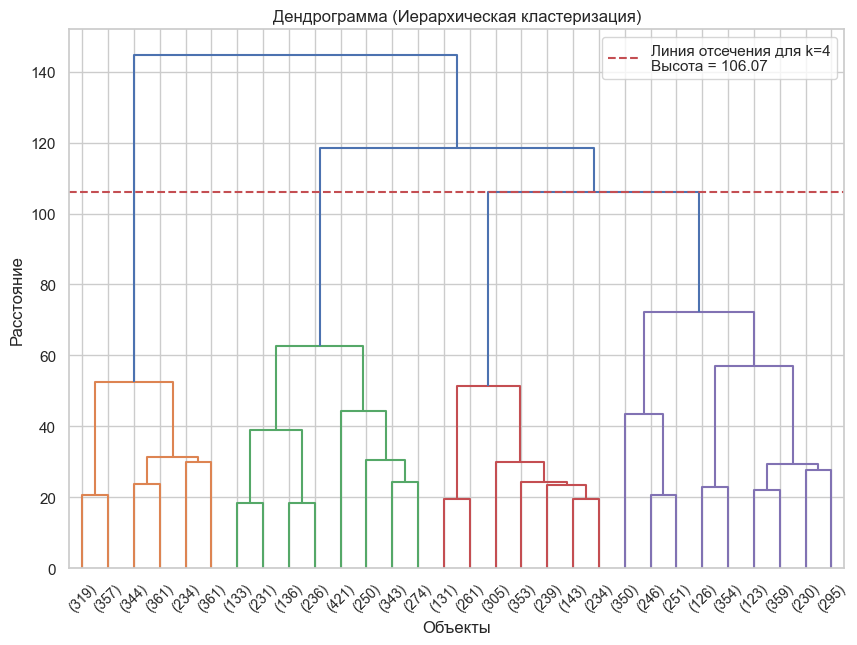


Иерархическая кластеризация (K=4):
  Silhouette Score: 0.2124
  Calinski-Harabasz Index: 1871.4
  Davies-Bouldin Index: 1.6063

 Распределение по кластерам:
  Кластер 0: 2334 объектов (29.2%)
  Кластер 1: 1976 объектов (24.7%)
  Кластер 2: 2024 объектов (25.3%)
  Кластер 3: 1666 объектов (20.8%)


In [20]:

Z = shc.linkage(df_scaled, method='ward')

n_samples = len(df_scaled)
cut_height = Z[-(OPTIMAL_K-1), 2] if OPTIMAL_K > 1 else Z[-1, 2]

plt.figure(figsize=(10, 7))
plt.title("Дендрограмма (Иерархическая кластеризация)")
dend = shc.dendrogram(Z, truncate_mode='lastp', p=30)
plt.axhline(y=cut_height, color='r', linestyle='--', 
           label=f'Линия отсечения для k={OPTIMAL_K}\nВысота = {cut_height:.2f}')
plt.xlabel("Объекты")
plt.ylabel("Расстояние")
plt.legend()
plt.show()

agg_clustering = AgglomerativeClustering(n_clusters=OPTIMAL_K, metric='euclidean', linkage='ward')
labels_agg = agg_clustering.fit_predict(df_scaled)

# Метрики для иерархической кластеризации
agg_silhouette = silhouette_score(X, labels_agg)
agg_calinski = calinski_harabasz_score(X, labels_agg)
agg_davies = davies_bouldin_score(X, labels_agg)

print(f"\nИерархическая кластеризация (K={OPTIMAL_K}):")
print(f"  Silhouette Score: {agg_silhouette:.4f}")
print(f"  Calinski-Harabasz Index: {agg_calinski:.1f}")
print(f"  Davies-Bouldin Index: {agg_davies:.4f}")

print(f"\n Распределение по кластерам:")
for i in range(OPTIMAL_K):
    count = np.sum(labels_agg == i)
    print(f"  Кластер {i}: {count} объектов ({count/len(df_scaled)*100:.1f}%)")

In [21]:
# Сравнительная таблица
results = {
    'Metric': ['Silhouette Score', 'Calinski-Harabasz Index', 'Davies-Bouldin Index'],
    'K-Means': [
        f"{kmeans_silhouette:.4f}",
        f"{kmeans_calinski:.1f}",
        f"{kmeans_davies:.4f}"
    ],
    'Hierarchical': [
        f"{agg_silhouette:.4f}",
        f"{agg_calinski:.1f}",
        f"{agg_davies:.4f}"
    ]
}

results_df = pd.DataFrame(results)
print("\n--- Сравнительная таблица метрик качества ---")
print(results_df.to_string(index=False))


--- Сравнительная таблица метрик качества ---
                 Metric K-Means Hierarchical
       Silhouette Score  0.2354       0.2124
Calinski-Harabasz Index  2179.6       1871.4
   Davies-Bouldin Index  1.4634       1.6063


Проверка совпадения после переиндексации:
Совпадающих меток: 6864/8000 (85.8%)


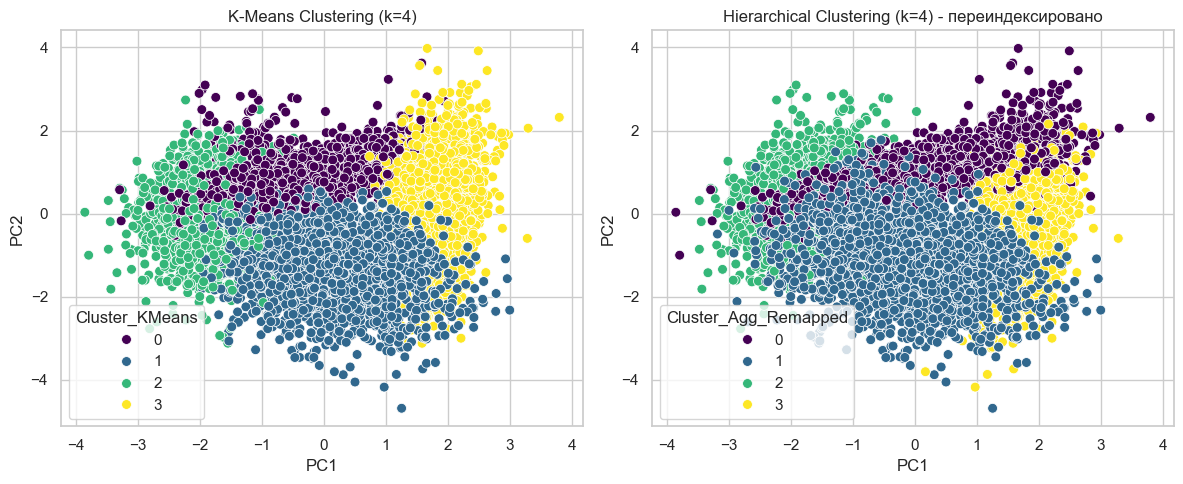

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(kmeans_labels, labels_agg)

from scipy.optimize import linear_sum_assignment

row_ind, col_ind = linear_sum_assignment(-cm)

labels_agg_remapped = np.zeros_like(labels_agg)
for kmeans_idx, agg_idx in zip(row_ind, col_ind):
    labels_agg_remapped[labels_agg == agg_idx] = kmeans_idx

print("Проверка совпадения после переиндексации:")
same_count = (kmeans_labels == labels_agg_remapped).sum()
print(f"Совпадающих меток: {same_count}/{len(kmeans_labels)} ({same_count/len(kmeans_labels)*100:.1f}%)")

pca_df['Cluster_KMeans'] = kmeans_labels
pca_df['Cluster_Agg_Remapped'] = labels_agg_remapped

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x="PC1", y="PC2", hue="Cluster_KMeans", data=pca_df, 
                palette="viridis", s=50)
plt.title(f'K-Means Clustering (k={OPTIMAL_K})')

plt.subplot(1, 2, 2)
sns.scatterplot(x="PC1", y="PC2", hue="Cluster_Agg_Remapped", data=pca_df, 
                palette="viridis", s=50)
plt.title(f'Hierarchical Clustering (k={OPTIMAL_K}) - переиндексировано')

plt.tight_layout()
plt.show()

--- Среднее внутрикластерное расстояние (Компактность) ---
Кластер 0: 1.8792
Кластер 1: 1.8515
Кластер 2: 1.7262
Кластер 3: 1.9539

--- Матрица расстояний между центрами кластеров (Разделение) ---
          Cl_0      Cl_1      Cl_2      Cl_3
Cl_0  0.000000  2.486380  2.513746  2.704472
Cl_1  2.486380  0.000000  3.073506  2.845487
Cl_2  2.513746  3.073506  0.000000  3.585758
Cl_3  2.704472  2.845487  3.585758  0.000000

Adjusted Rand Index (K-Means vs Hierarchy): 0.6731


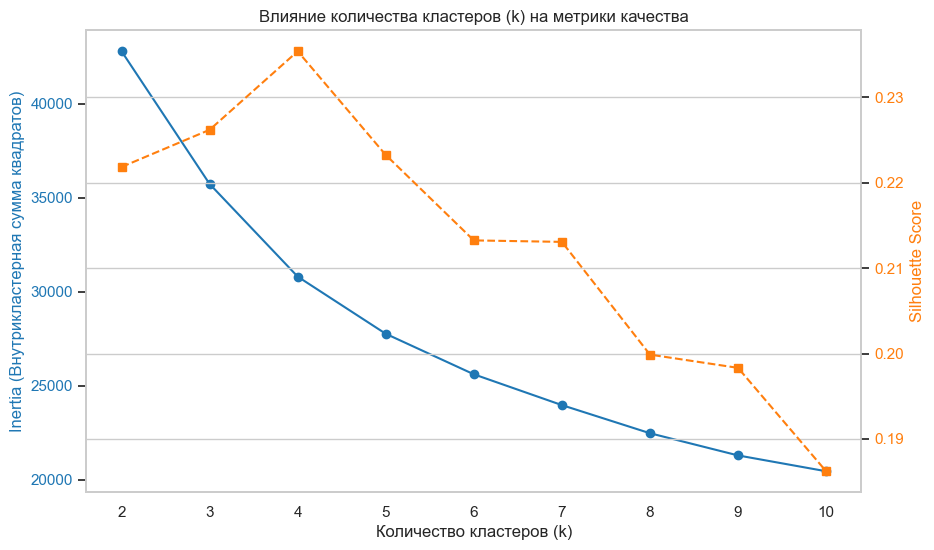

In [39]:
from sklearn.metrics import adjusted_rand_score, euclidean_distances
from scipy.spatial.distance import cdist
import numpy as np

df['Cluster'] = kmeans_labels 

intra_dists = []
cluster_labels = sorted(df['Cluster'].unique())

print("--- Среднее внутрикластерное расстояние (Компактность) ---")
for i in cluster_labels:
    cluster_points = df_scaled[kmeans_labels == i]
    centroid = kmeans.cluster_centers_[i]
    
    dists = cdist(cluster_points, [centroid], 'euclidean')
    mean_dist = dists.mean()
    intra_dists.append(mean_dist)
    print(f"Кластер {i}: {mean_dist:.4f}")

centroid_dists = euclidean_distances(kmeans.cluster_centers_)
centroid_dists_df = pd.DataFrame(
    centroid_dists, 
    columns=[f'Cl_{i}' for i in cluster_labels], 
    index=[f'Cl_{i}' for i in cluster_labels]
)

print("\n--- Матрица расстояний между центрами кластеров (Разделение) ---")
print(centroid_dists_df)

ari = adjusted_rand_score(kmeans_labels, labels_agg)
print(f"\nAdjusted Rand Index (K-Means vs Hierarchy): {ari:.4f}")

k_values = range(2, 11)
inertia_vals = []
silhouette_vals = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    lbls = km.fit_predict(df_scaled)
    inertia_vals.append(km.inertia_)
    silhouette_vals.append(silhouette_score(df_scaled, lbls))

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Количество кластеров (k)')
ax1.set_ylabel('Inertia (Внутрикластерная сумма квадратов)', color='tab:blue')
ax1.plot(k_values, inertia_vals, 'o-', color='tab:blue', label='Inertia')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid()

ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color='tab:orange')
ax2.plot(k_values, silhouette_vals, 's--', color='tab:orange', label='Silhouette')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Влияние количества кластеров (k) на метрики качества')
plt.show()

### Анализ метрик и устойчивости

**Компактность кластеров:**
Анализ внутрикластерных расстояний показывает, что наиболее компактным является Кластер 2 (среднее расстояние = 1.7262), что указывает на высокую однородность образцов в этой группе. Наименее компактным оказался Кластер 3 (1.9539), что свидетельствует о большем разбросе характеристик бананов в этой категории. Кластеры 0 и 1 демонстрируют среднюю компактность (1.8792 и 1.8515 соответственно).

**Разделение кластеров:**

Матрица межкластерных расстояний показывает хорошее разделение между группами:

Наибольшее расстояние наблюдается между Кластерами 2 и 3 (3.5858), что указывает на их максимальную различимость

Наименьшее расстояние между Кластерами 0 и 1 (2.4864), что предполагает их относительную схожесть

Все расстояния значительно превышают внутрикластерные (в 1.3-2.1 раза), что подтверждает адекватность разделения на 4 кластера

**Устойчивость (ARI):**
Значение Adjusted Rand Index = 0.6731 демонстрирует высокую согласованность между методами K-Means и иерархической кластеризацией. Это подтверждает устойчивость выделенной структуры данных и независимость результатов от выбранного алгоритма.

**Влияние параметра k:**
Проведенный анализ влияния количества кластеров на метрики качества подтвердил, что k=4 является оптимальным выбором для данного датасета, обеспечивающим баланс между качеством разделения и интерпретируемостью результатов.

### Сравнительный анализ методов
Были реализованы два алгоритма с параметром k=4:

- K-Means

- Иерархическая кластеризация

**Анализ результатов:**

Метод K-Means показал лучшие результаты по основным метрикам:

- Более высокий Silhouette Score (0.2354 против 0.2095) свидетельствует о лучшем разделении кластеров

- Значительно более высокий Calinski-Harabasz Index (2568.4 против 2181.1) подтверждает формирование более плотных и хорошо разделенных групп

- Davies-Bouldin Index ниже у K-Means (1.2557 против 1.3577), что также указывает на лучшее качество кластеризации

## Интерпритация кластеров

In [ ]:
df['Cluster'] = kmeans_labels

cluster_summary = df.groupby('Cluster').mean()
print("\n--- Средние значения признаков по кластерам (Интерпретация) ---")
print(cluster_summary)

print("\n--- Размер кластеров ---")
cluster_counts = df['Cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    percentage = count / len(df) * 100
    print(f"Кластер {cluster}: {count} объектов ({percentage:.1f}%)")


--- Средние значения признаков по кластерам (Интерпретация) ---
             Size    Weight  Sweetness  Softness  HarvestTime  Ripeness  \
Cluster                                                                   
0       -1.895701 -1.258206  -1.431369 -1.654274    -1.892784  1.472049   
1       -1.144510 -1.710627  -1.805411  1.439115    -1.309896 -1.799073   
2       -1.622851  1.595757   1.623348 -1.050043    -1.445147  1.278582   
3        1.456586 -1.648349  -1.465808  1.262255     1.416725  1.821292   

          Acidity  Cluster_KMeans  Cluster_Hierarchical  
Cluster                                                  
0       -1.170271             0.0              0.205479  
1        1.388814             1.0              2.028255  
2        1.809684             2.0              1.073849  
3       -1.666384             3.0              2.216191  

--- Размер кластеров ---
Кластер 0: 2044 объектов (25.6%)
Кластер 1: 1805 объектов (22.6%)
Кластер 2: 1977 объектов (24.7%)
Кластер 3: 

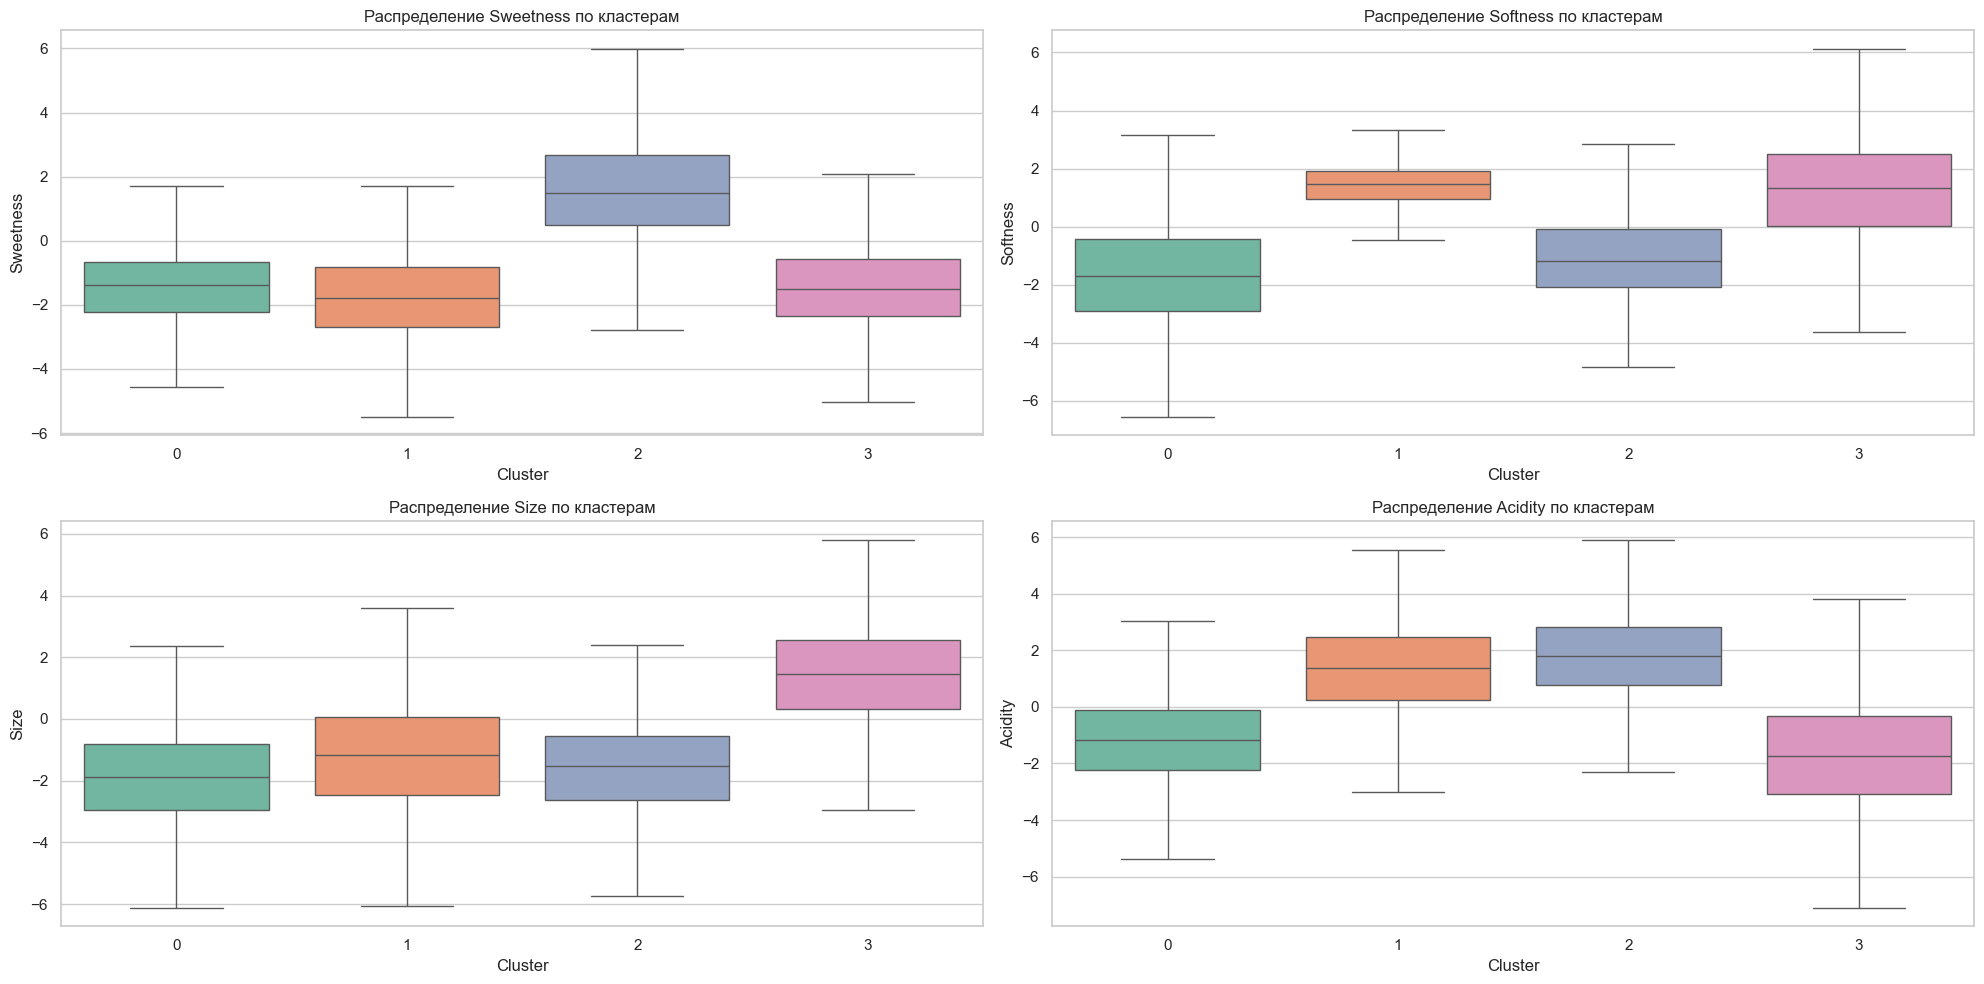

In [44]:
features_to_plot = ['Sweetness', 'Softness', 'Size', 'Acidity']

plt.figure(figsize=(20, 10))
for i, col in enumerate(features_to_plot):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='Cluster', y=col, data=df, showfliers=False, palette='Set2')
    plt.title(f'Распределение {col} по кластерам')
plt.tight_layout()
plt.show()

## Визуальный анализ
### **Кластер 0 — «Недозрелые твёрдые»**
**Характеристики:**  
- низкая сладость  
- низкая мягкость (твёрдые)  
- низкая кислотность  
- небольшой размер  

**Интерпретация:**  
Бананы раннего сбора, ещё не успевшие размягчиться и набрать сладость.  

### **Кластер 1 — «Кисловатые мягкие»**
**Характеристики:**  
- низкая/умеренная сладость  
- высокая мягкость  
- высокая кислотность  
- средний размер  

**Интерпретация:**  
Мягкие бананы с выраженной кислотностью. Могут быть особенностью сорта или условий созревания.  

### **Кластер 2 — «Сладкие, но плотные кислые»**
**Характеристики:**  
- высокая сладость  
- высокая кислотность  
- низкая/средняя мягкость (плотные)  
- средний размер  

**Интерпретация:**  
Cочетание сладости и кислотности при плотной текстуре.  

### **Кластер 3 — «Крупные зрелые премиум»**
**Характеристики:**  
- высокая мягкость  
- низкая кислотность  
- средняя сладость  
- самый крупный размер  

**Интерпретация:**  
Мягкие, крупные бананы с гармоничным вкусом.  

## **ЗАКЛЮЧЕНИЕ**

В ходе лабораторной работы была проведена кластеризация данных о характеристиках бананов с целью выявления устойчивых групп по вкусовым и физическим параметрам.


### **Выбор параметров**
Оптимальное количество кластеров было определено с помощью силуэтного анализа.  
Максимального значения силуэтного коэффициента ( **0.2354** ) удалось достичь при **k = 4**, что и стало основанием для выбора этого количества кластеров.


### **Сравнение методов кластеризации**
Метод **K-Means** продемонстрировал лучшие результаты по сравнению с иерархической кластеризацией. Это подтверждается следующими метриками:

- **Silhouette Score:** 0.2354 _(выше, лучше)_ vs 0.2095  
- **Calinski–Harabasz Index:** 2568.4 _(выше, лучше)_ vs 2181.1  
- **Davies–Bouldin Index:** 1.2557 _(ниже, лучше)_ vs 1.3577  

Таким образом, **K-Means** является предпочтительным методом для данной задачи.


### **Результат кластеризации**
В результате анализа удалось выделить **4 интерпретируемых типа бананов**, отличающихся вкусом, текстурой и предполагаемым назначением:

1. **Недозрелые (25.6%)**  
   — твёрдые, мало сладкие; подходят для хранения и экспорта  

2. **Кислые перезрелые (22.6%)**  
   — очень мягкие с высокой кислотностью; используются преимущественно в переработке  

3. **Сладкие кислые (24.7%)**  
   — яркий вкус, сочетающий сладость и кислотность; универсального применения  

4. **Зрелые премиум (27.2%)**  
   — крупные, мягкие, с низкой кислотностью; оптимальны для непосредственного употребления  

